In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

# Parameters
SPEED_THRESHOLD = 4  # m/s
MIN_STOP_DURATION = 1.0  # seconds
DIST_THRESH = 2.6
EXPORT_INTERVAL = 0.16  # seconds
PED_BOX = (0.3, 0.3)
CAR_BOX = (3.72, 1.44)         

# ----------------------------------
# Helpers
# ----------------------------------

def filter_stopped_vehicles(df, speed_col='speed', time_col='TimeStamp'):
    """Filter out stopped vehicles longer than threshold"""
    df = df.copy()
    df['time_diff'] = df.groupby('Track ID')[time_col].diff()
    df['is_stopped'] = df[speed_col] < SPEED_THRESHOLD
    stop_groups = (df['is_stopped'] != df['is_stopped'].shift()).cumsum()
    df['stop_duration'] = df.groupby(['Track ID', stop_groups])['time_diff'].cumsum()
    return df[~((df['is_stopped']) & (df['stop_duration'] >= MIN_STOP_DURATION))].drop(columns=['time_diff', 'is_stopped', 'stop_duration'])

def get_rotated_corners(x, y, heading, length, width):
    """Return coordinates of rotated bounding box corners"""
    half_l, half_w = length / 2, width / 2
    corners = np.array([
        [ half_l,  half_w],
        [ half_l, -half_w],
        [-half_l, -half_w],
        [-half_l,  half_w]
    ])
    rad = np.radians(heading)
    rot = np.array([
        [np.cos(rad), -np.sin(rad)],
        [np.sin(rad),  np.cos(rad)]
    ])
    return (corners @ rot.T) + np.array([x, y])

def get_closest_corners(row):
    """Get direction vector and min distance between closest corners"""
    ped_corners = get_rotated_corners(row['x_smooth_ped'], row['y_smooth_ped'], row['HA_ped'], *PED_BOX)
    car_corners = get_rotated_corners(row['x_smooth_car'], row['y_smooth_car'], row['HA_car'], *CAR_BOX)
    dists = cdist(ped_corners, car_corners)
    idx = np.unravel_index(np.argmin(dists), dists.shape)
    min_dist = dists[idx]
    direction_vec = car_corners[idx[1]] - ped_corners[idx[0]]
    return min_dist, direction_vec

def calculate_attc(row):
    """Compute ATTC using projection of relative motion on direction vector"""
    min_dist, direction_vec = get_closest_corners(row)
    norm = np.linalg.norm(direction_vec)
    if norm == 0:
        return np.inf
    unit_vec = direction_vec / norm

    rel_v = np.array([
        row['vx_smooth_ped'] - row['vx_smooth_car'],
        row['vy_smooth_ped'] - row['vy_smooth_car']
    ])
    rel_a = 0.16 * np.array([
        row['ax_ped'] - row['ax_car'],
        row['ay_ped'] - row['ay_car']
    ])

    closing_rate = -np.dot(rel_v, unit_vec) + np.dot(rel_a, unit_vec)
    return min_dist / closing_rate if closing_rate > 0 else np.inf

# ----------------------------------
# Load Data
# ----------------------------------

df_ped = pd.read_csv(r"D:\T\test_codeEVT\nd\ped_smooth.csv")
df_car = pd.read_csv(r"D:\T\test_codeEVT\nd\car_smooth.csv")
df_car['speed'] = np.sqrt(df_car['vx_smooth']**2 + df_car['vy_smooth']**2)

# Filter stopped vehicles
print(f"Original carrcycle count: {len(df_car)}")
df_car = filter_stopped_vehicles(df_car, speed_col='speed')
print(f"Filtered carrcycle count: {len(df_car)}")
import pandas as pd

print(df_car['speed'].mean())
# Calculate yaw rates
for df in [df_ped, df_car]:
    df['yaw_rate'] = df.groupby('Track ID').apply(
        lambda x: x['HA'].diff() / x['TimeStamp'].diff()
    ).reset_index(level=0, drop=True)

# Round timestamps
df_ped['Time_rounded'] = (df_ped['TimeStamp'] / EXPORT_INTERVAL).round() * EXPORT_INTERVAL
df_car['Time_rounded'] = (df_car['TimeStamp'] / EXPORT_INTERVAL).round() * EXPORT_INTERVAL


Original carrcycle count: 329613
Filtered carrcycle count: 39660
5.646480769257238


C:\Users\IST LAB 1\AppData\Local\Temp\ipykernel_11532\929929306.py:89: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['yaw_rate'] = df.groupby('Track ID').apply(
C:\Users\IST LAB 1\AppData\Local\Temp\ipykernel_11532\929929306.py:89: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['yaw_rate'] = df.groupby('Track ID').apply(


In [16]:

# ----------------------------------
# Merge and Process
# ----------------------------------

merged = pd.merge(
    df_ped, 
    df_car, 
    on='Time_rounded', 
    suffixes=('_ped', '_car')
)

merged['Center_dist'] = np.hypot(
    merged['x_smooth_ped'] - merged['x_smooth_car'],
    merged['y_smooth_ped'] - merged['y_smooth_car']
)

# Filter by center threshold
results = merged[merged['Center_dist'] <= DIST_THRESH].copy()

# Calculate ATTC using corrected method
results['ATTC'] = results.apply(calculate_attc, axis=1)
results[['mindis', 'direction_vec']] = results.apply(
    lambda row: pd.Series(get_closest_corners(row)),
    axis=1
)
# Output
output = results[['Track ID_ped', 'Track ID_car', 'TimeStamp_ped', 'ATTC']].rename(columns={
    'Track ID_ped': 'Ped_ID',
    'Track ID_car': 'car_ID',
    'TimeStamp_ped': 'TimeStamp'
})
print(output)
len(results[(results['ATTC']<3) & (results['mindis']<1)][['Track ID_ped', 'Track ID_car']].drop_duplicates())

        Ped_ID  car_ID  TimeStamp      ATTC
5605      1285    1348     473.72       inf
5608      1285    1348     473.88       inf
5611      1285    1348     474.04  5.908686
5614      1285    1348     474.20  0.723825
5616      1285    1348     474.36  1.499736
...        ...     ...        ...       ...
181612   16153   15932    5513.20       inf
181613   16153   15932    5513.36       inf
181648   16153   15932    5520.56  0.638753
181651   16153   15932    5520.72       inf
181652   16153   15932    5520.72  0.324957

[566 rows x 4 columns]


50

In [17]:
len(results[(results['ATTC']<0.2) & (results['mindis']<1)][['Track ID_ped', 'Track ID_car','TimeStamp_ped']].drop_duplicates())

26

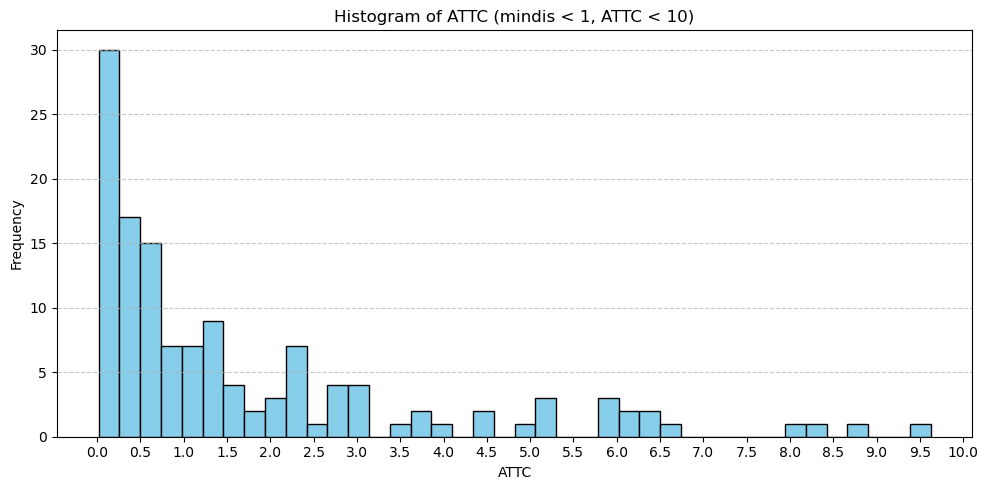

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the data
subset = results[(results['ATTC'] < 10) & (results['mindis'] < 1)]

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(subset['ATTC'], bins=40, color='skyblue', edgecolor='black')

# Set x-axis ticks at 0.5 intervals
plt.xticks(np.arange(0, 10.5, 0.5))  # From 0 to 10 in 0.5 steps

# Labels and title
plt.xlabel('ATTC')
plt.ylabel('Frequency')
plt.title('Histogram of ATTC (mindis < 1, ATTC < 10)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [19]:
results[(results['ATTC']<0.1) & (results['mindis']<1)][['Track ID_ped', 'Track ID_car', 'TimeStamp_ped', 'ATTC']]

,Track ID_ped,Track ID_car,TimeStamp_ped,ATTC
7818,1524,1559,551.08,0.077120
58406,6198,6228,2320.84,0.046256
72133,7316,7063,2703.28,0.029970
72137,7316,7063,2703.44,0.029827
82123,8028,8070,2943.68,0.053168
98255,9026,9074,3290.28,0.033378
98256,9026,9074,3290.60,0.040117
99527,9253,9345,3367.72,0.073439
112488,10514,10165,3770.60,0.086541
135524,12529,12283,4369.04,0.016664


In [20]:
# Create new DataFrame with selected and renamed columns
conflict_summary = results[[
    'Track ID_ped',        # Pedestrian ID
    'Track ID_car',       # Vehicle ID
    'Type_car',           # Vehicle type
    'TimeStamp_ped',       # Timestamp
    'mindis',              # Minimum corner distance
    'ATTC'                 # ATTC value
]].copy()

# Rename columns
conflict_summary.rename(columns={
    'Track ID_ped': 'PED_ID',
    'Track ID_car': 'VEH_ID',
    'Type_car': 'TYPE',
    'TimeStamp_ped': 'TIMESTAMP',
    'mindis': 'MIN_COR_DIS',
    'ATTC': 'ATTC'
}, inplace=True)

# Preview
print(conflict_summary.head())


      PED_ID  VEH_ID  TYPE  TIMESTAMP  MIN_COR_DIS      ATTC
5605    1285    1348   Car     473.72          NaN       inf
5608    1285    1348   Car     473.88     0.529479       inf
5611    1285    1348   Car     474.04     0.530783  5.908686
5614    1285    1348   Car     474.20     0.369116  0.723825
5616    1285    1348   Car     474.36     0.494954  1.499736


In [21]:
conflict_summary.to_csv(r"D:\T\test_codeEVT\ATTC_Data/Car_Ped.csv", index=False)